# *** Note that ***
# To run this notebook, you need GPU

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preporcessing
import re
from sklearn.model_selection import train_test_split

# model
from transformers import BertTokenizer, BertModel
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Import train and test data

In [2]:
#学習用データと評価用データの読み込み
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [4]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [5]:
#評価用データの中身を確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


# Preprocessing

In [6]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する

def cleaning(data, training):
    tmp_data = data.copy()
    clean_texts = []
    for text in tmp_data["description"]:
        # htmlタグを削除
        text = remove_tag(text)
        # replace duble space with single space
        text = text.replace('  ', ' ')
        clean_texts.append(text)
    tmp_data["description"] = clean_texts
    if training:
        tmp_data["jobflag"] += -1
    return tmp_data

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub(' ',x)

In [7]:
cleaned_train = cleaning(train, training=True)
cleaned_test = cleaning(test, training=False)

In [8]:
# クリーニング結果の確認
print('#original\n', train['description'][0])
print("-----")
print('#cleaned\n', cleaned_train['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
  Develop cutting-edge web applications that perform superbly across all platforms. Work in a highly colla

In [9]:
print(cleaned_train['description'].shape)
print(cleaned_train['jobflag'].head())

(1516,)
0    2
1    2
2    3
3    2
4    3
Name: jobflag, dtype: int64


In [10]:
# #学習用データを分割して, 投稿前の精度検証を行う
data_train, data_valid = train_test_split(cleaned_train, stratify=cleaned_train['jobflag'], test_size=0.3, random_state=0)

# Model

before using transformers, install transformers from huggingface  
`conda install -c huggingface transformers`

In [11]:
# hyper-parameters
epochs = 10
batch_size = 128
max_length = 512

In [12]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, training):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.training = training
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        txt = self.data["description"].iloc[index] 
        
        inputs = self.tokenizer.encode_plus(
            txt, 
            None,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]
        if self.training:
            target = torch.tensor(self.data["jobflag"].iloc[index])
            target = F.one_hot(target, num_classes=4).float()
            return ids, mask, token_type_ids, target
        else:
            return ids, mask, token_type_ids

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [14]:
train_dataset = BertDataset(data_train, tokenizer, max_length=max_length, training=True) 
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [15]:
valid_dataset = BertDataset(data_valid, tokenizer, max_length=max_length, training=True) 
valid_dataloader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size=batch_size)

In [16]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
#         self.fc = nn.Linear(768, 768)
        self.final_layer = nn.Linear(768, 4)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, ids, mask, token_type_ids):
        _, out = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
#         out = self.fc(out_bert)
#         out = self.final_layer(out+out_bert) # skipping connection
        out = self.final_layer(out)
        out = self.softmax(out)
        
        return out

# Loss function

In [17]:
# Focal loss

def focal_loss(alpha, gamma=2.0, reduction="none"):
#     alpha= 0.25,
#     gamma: float = 2,
#     reduction: str = "none",

    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default = 0.25
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    gamma =  torch.tensor(gamma, device=device)
    def categorical_focal_loss(inputs, targets):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        epsilon = 1e-10
        epsilon = torch.tensor(epsilon, device=device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        ce_loss = -targets * torch.log(inputs+epsilon)
        loss = alpha * torch.pow(1 - inputs, gamma) * ce_loss #ce_loss * ((1 - p_t) ** gamma)

    #     if alpha >= 0:
    #         alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    #         loss = alpha_t * loss

        if reduction == "mean":
            loss = loss.mean()
        elif reduction == "sum":
            loss = loss.sum()
#         else:
#             loss = loss.sum()
#             loss = loss.mean()

        return loss
    
    return categorical_focal_loss

In [18]:
# calculate alpha
alpha = len(cleaned_train) / cleaned_train['jobflag'].value_counts()
alpha = alpha.sort_index()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alpha = torch.tensor(alpha, device=device)
# alpha = alpha / sum(alpha)
print(alpha.shape)
print(alpha)

torch.Size([4])
tensor([ 3.2393, 17.2273,  3.3319,  3.0020], device='cuda:0',
       dtype=torch.float64)


In [19]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, gamma=0.5, reduction="sum") # default (gamma = 2.0)
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# print(model)

In [21]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.pooler.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

In [22]:
# To visualize the process of training
def visuzlize_training_process(train_losses, train_accs, val_losses, val_accs):
    #　graph for checking accuracy
    plt.figure(figsize=(10,5))
    plt.plot(train_accs, label = 'train_acc')
    plt.plot(val_accs, label = 'val_acc')
    plt.xticks(np.arange(1, epochs+1, 1))
    plt.title('Accuracy Graph')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('./results/bert_epoch_20_acccuracy.png')
    plt.show()
    plt.close()

    #　graph for checking loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label = 'train_loss')
    plt.plot(val_losses, label = 'val_loss')
    plt.xticks(np.arange(1, epochs+1, 1))
    plt.title('Loss Graph')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('./results/bert_epoch_20_loss.png')
    plt.show()
    plt.close()

In [23]:
# To evaluate validation loss and accuracy in training loop
def caluculate_val_loss_acc(model, loss_fn, valid_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    val_loss = 0.0
    val_correct = 0.0
    with torch.no_grad():
        for ids, mask, token_type_ids, target in tqdm(valid_dataloader):
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            token_type_ids = torch.reshape(token_type_ids, (token_type_ids.shape[0], token_type_ids.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(output.cpu(), target)
            
            # calculate valid loss and accuracy
            # convert one-hot to label
            val_loss += loss.item() 
            val_pred = torch.argmax(output.cpu(), dim=-1)
            target_label = torch.argmax(target, dim=-1)
            val_correct += torch.sum(val_pred == target_label) 
            
        val_loss = val_loss / len(valid_dataloader.dataset)
        val_acc = val_correct / len(valid_dataloader.dataset)
            
    return val_loss, val_acc

In [24]:
# This function is for training loop
def train_model(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer):
    # If you can use GPU, set up GPU. Otherwise, use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-----------------------------------")
        
        train_loss = 0.0
        train_correct = 0.0
        for ids, mask, token_type_ids, target in tqdm(train_dataloader):
            # We need to reshape data here, I dont know why
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            token_type_ids = torch.reshape(token_type_ids, (token_type_ids.shape[0], token_type_ids.shape[2]))
            
            # send data to GPU
            ids = ids.to(device)
            mask = mask.to(device)
            token_type_ids = token_type_ids.to(device)
            target = target.to(device)
            
            # train and backforward
            optimizer.zero_grad()
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(output, target) 
            loss.backward()
            optimizer.step()
            
            # calculate train loss and accuracy
            # convert one-hot to label
            train_loss += loss.item() 
            train_pred = torch.argmax(output, dim=-1)
            target_label = torch.argmax(target, dim=-1)
            train_correct += torch.sum(train_pred == target_label) 
            
        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_correct / len(train_dataloader.dataset)
        val_loss, val_acc = caluculate_val_loss_acc(model, loss_fn, valid_dataloader)
        
        print("Train Loss: {:.4f} Train Acc: {:.4f}".format(train_loss, train_acc))
        print("Valid Loss: {:.4f} Valid Acc: {:.4f}".format(val_loss, val_acc))
        train_losses.append(train_loss)
        train_accs.append(train_acc.cpu())
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    visuzlize_training_process(train_losses, train_accs, val_losses, val_accs)        
    return model

Epoch 1/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.42s/it]


Train Loss: 0.0111 Train Acc: 0.3808
Valid Loss: 0.0108 Valid Acc: 0.5231
Epoch 2/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.63s/it]


Train Loss: 0.0101 Train Acc: 0.5862
Valid Loss: 0.0103 Valid Acc: 0.5912
Epoch 3/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.62s/it]


Train Loss: 0.0094 Train Acc: 0.6343
Valid Loss: 0.0100 Valid Acc: 0.6022
Epoch 4/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.46s/it]


Train Loss: 0.0092 Train Acc: 0.6579
Valid Loss: 0.0099 Valid Acc: 0.5956
Epoch 5/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.66s/it]


Train Loss: 0.0091 Train Acc: 0.6786
Valid Loss: 0.0097 Valid Acc: 0.6308
Epoch 6/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.45s/it]


Train Loss: 0.0089 Train Acc: 0.7135
Valid Loss: 0.0098 Valid Acc: 0.6132
Epoch 7/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.50s/it]


Train Loss: 0.0087 Train Acc: 0.7352
Valid Loss: 0.0097 Valid Acc: 0.6418
Epoch 8/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.70s/it]


Train Loss: 0.0086 Train Acc: 0.7361
Valid Loss: 0.0096 Valid Acc: 0.6484
Epoch 9/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.65s/it]


Train Loss: 0.0085 Train Acc: 0.7512
Valid Loss: 0.0096 Valid Acc: 0.6593
Epoch 10/10
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.48s/it]

Train Loss: 0.0084 Train Acc: 0.7653
Valid Loss: 0.0095 Valid Acc: 0.6725


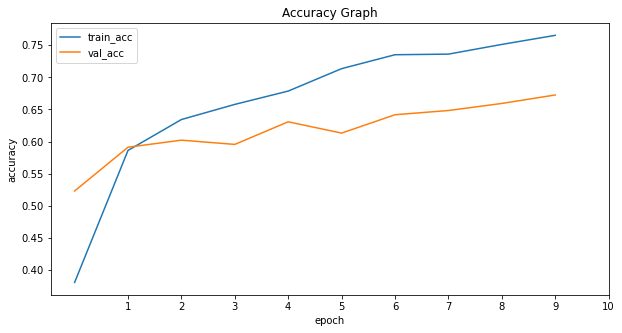

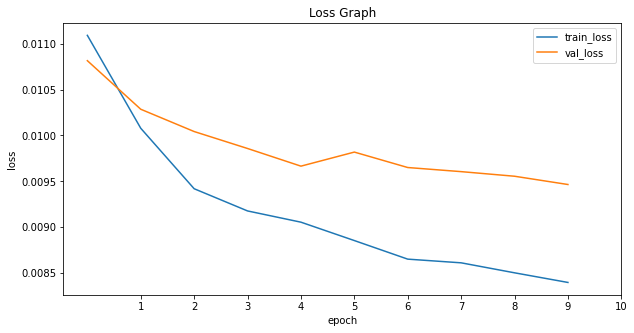

In [25]:
model = train_model(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer)

In [26]:
# this is for evaluating model using validation data
def evaluation(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preds = []
    targets = []
    with torch.no_grad():
        for ids, mask, token_type_ids, target in tqdm(dataloader):
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            token_type_ids = torch.reshape(token_type_ids, (token_type_ids.shape[0], token_type_ids.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            pred = torch.argmax(output.cpu(), dim=-1)
            target = torch.argmax(target, dim=-1)
            preds.extend(pred)
            targets.extend(target)
            
    return preds, targets

In [27]:
preds, targets = evaluation(model, valid_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.44s/it]


/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           1      0.674     0.443     0.534       140
           2      0.000     0.000     0.000        26
           3      0.678     0.905     0.775       137
           4      0.667     0.789     0.723       152

    accuracy                          0.673       455
   macro avg      0.505     0.534     0.508       455
weighted avg      0.634     0.673     0.639       455



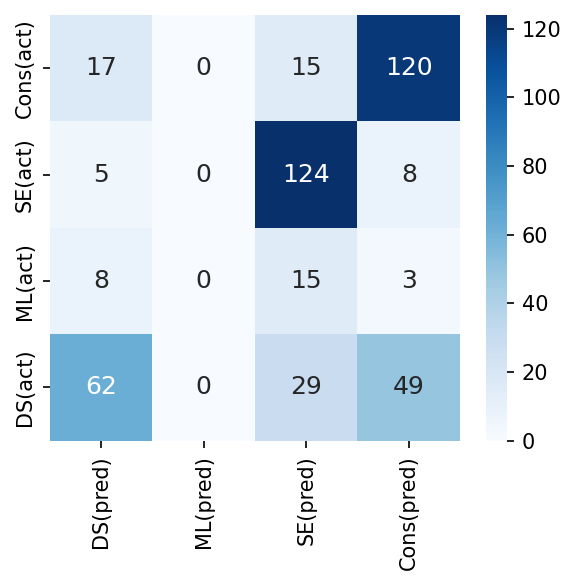

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
l_preds = list(map(lambda x: x + 1, preds))
l_targets = list(map(lambda x: x + 1, targets))
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(l_targets, l_preds, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
plt.savefig('./results/bert_epoch_20_heatmap.png')

print(classification_report(l_targets, l_preds, labels=labels, digits=3))

# Submit 

In [29]:
# train model using all data
submit_dataset = BertDataset(cleaned_train, tokenizer, max_length=max_length, training=True) 
submit_dataloader = DataLoader(dataset=submit_dataset, shuffle=True, batch_size=batch_size)

In [30]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, gamma=0.5, reduction="sum") # default (gamma = 2.0)
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.pooler.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

In [32]:
# This function is for training loop
def train_submit_model(epochs, dataloader, model, loss_fn, optimizer):
    # If you can use GPU, set up GPU. Otherwise, use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-----------------------------------")
        for ids, mask, token_type_ids, target in tqdm(dataloader):
            # We need to reshape data here, I dont know why
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            token_type_ids = torch.reshape(token_type_ids, (token_type_ids.shape[0], token_type_ids.shape[2]))
            
            # send data to GPU
            ids = ids.to(device)
            mask = mask.to(device)
            token_type_ids = token_type_ids.to(device)
            target = target.to(device)
            
            # train and backforward
            optimizer.zero_grad()
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(output, target) 
            loss.backward()
            optimizer.step()
       
    return model

In [33]:
model = train_submit_model(epochs, submit_dataloader, model, loss_fn, optimizer)

Epoch 1/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [02:27<00:00, 12.32s/it]


Epoch 2/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [01:20<00:00,  6.67s/it]


Epoch 3/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 4/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 5/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 6/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 7/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 8/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 9/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 10/10
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.11s/it]


In [34]:
torch.save(model.state_dict(), './results/bert_epoch_20.pth')

In [35]:
# model.load_state_dict(torch.load('./results/bert_epoch_20.pth'))

In [36]:
test_dataset = BertDataset(cleaned_test, tokenizer, max_length=max_length, training=False) 
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

In [37]:
def prediction(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preds = []
    with torch.no_grad():
        for ids, mask, token_type_ids in tqdm(dataloader):
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            token_type_ids = torch.reshape(token_type_ids, (token_type_ids.shape[0], token_type_ids.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            pred = torch.argmax(output.cpu(), dim=-1)
            preds.extend(pred.numpy())
            
    return preds

In [38]:
pred_sub = prediction(model, test_dataloader)
pred_sub = list(map(lambda x: x + 1, pred_sub))

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.17s/it]


In [39]:
# print(pred_sub['jobflag'].value_counts())
# pred_sub['jobflag'].value_counts().plot(kind = 'bar')
# print(pred_sub)

In [40]:
sample_submit_df = pd.DataFrame(list(zip(list(test['id'].values), pred_sub)), columns=["id", "pred"])
sample_submit_df.to_csv('../ensemble/bert/test.csv', header=None, index=None)

3    568
4    498
1    451
Name: pred, dtype: int64


<AxesSubplot:>

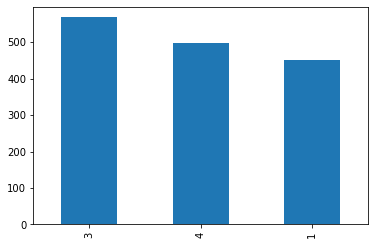

In [41]:
print(sample_submit_df['pred'].value_counts())
sample_submit_df['pred'].value_counts().plot(kind = 'bar')